In [3]:
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, ExpandingStd, ExponentiallyWeightedMean
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from utilsforecast.feature_engineering import fourier, trend, pipeline
from mlforecast.utils import PredictionIntervals

from numba import njit
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, TargetEncoder

from sklearn.linear_model import LinearRegression
from window_ops.shift import shift_array

from xgboost import XGBRegressor
from catboost import CatBoostRegressor


# Suppress warnings
warnings.filterwarnings('ignore')

c:\Users\UX433F\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Import MLForecast_Evaluator and helper functions:

In [4]:
import sys
import os

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the system path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now you can import the Evaluator class
from fao_utils import MLForecast_Evaluator, query_country

# Load data and preprocess it

In [5]:
data = pd.read_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\full_country_dataset_v2_imputed.parquet')

### Select only World and continents

In [6]:
selected_regions = [5000, 5100, 5203, 5207, 5300, 5400, 5500]
data = data[data['Area Code'].isin(selected_regions)]

In [7]:
data.Area.unique()

array(['World', 'Africa', 'Northern America', 'South America', 'Asia',
       'Europe', 'Oceania'], dtype=object)

In [8]:
projections = pd.read_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\population_projections.parquet')
projections = projections[projections['Area Code'].isin(selected_regions)]

In [9]:
projections.head()

,Area Code,Area,Year,Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No
2259,5000.0,World,2022,7975105.157
2260,5000.0,World,2023,8045311.446
2261,5000.0,World,2024,8118835.991
2262,5000.0,World,2025,8191988.467
2263,5000.0,World,2026,8264364.506


### Select FORECASTING TARGET:

Por ahora a modo de ejemplo, voy a utilizar "Total_Energy_Emissions_(CO2)_kt"

In [10]:
target = "Total_Energy_Emissions_(CO2)_kt"

In [11]:
# Will test on "Total_Energy_Emissions_(CO2)_kt"
data = data.rename(columns={"Area": "unique_id", "Year": "ds", 
                            target: "y",
                            "Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No": "population_1000s"})

cols = ["unique_id", "ds", "y", "population_1000s"]
data = data[cols].dropna()

In [12]:
# Will test on "Total_Energy_Emissions_(CO2)_kt"
projections = projections.rename(columns={"Area": "unique_id", "Year": "ds", 
                            "Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No": "population_1000s"})

cols = ["unique_id", "ds", "population_1000s"]
projections = projections[cols].dropna()

In [13]:
train_index = sorted(list(data["ds"].unique()))[:-5]
valid_index = sorted(list(data["ds"].unique()))[-5:]

In [14]:
train = data.loc[data['ds'].isin(train_index)]
valid = data.loc[data['ds'].isin(valid_index)]
valid.sample(5)

,unique_id,ds,y,population_1000s
11338,Europe,2020,123857.5731,746225.359
11336,Europe,2018,130076.0939,745359.133
10624,Africa,2020,36052.2067,1360677.233
11042,South America,2018,50602.6990,424740.675
11044,South America,2020,49103.5728,431530.043


In [15]:
# XGBRegressor
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    reg_lambda=1,
    reg_alpha=1,
    random_state=42
)

# List of models
models = [xgb]

## Create target lags and lag transformations

In [16]:
@njit
def ratio_over_previous(x, offset=1):
    """Computes the ratio between the current value and its `offset` lag"""
    return x / shift_array(x, offset=offset)

@njit
def diff_over_previous(x, offset=1):
    """Computes the difference between the current value and its `offset` lag"""
    return x - shift_array(x, offset=offset)

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=models,
    freq=1,
    lags=[1,2,3],
    lag_transforms={
        1: [
            RollingMean(window_size=3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.7), #Higher alpha gives more importance to recent years
            ExpandingStd(),
            ratio_over_previous, (ratio_over_previous, 2),
            diff_over_previous, (diff_over_previous, 2)
            ],
        2: [
            RollingMean(window_size=3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.7), #Higher alpha gives more importance to recent years
            ExpandingStd(),
            ratio_over_previous, (ratio_over_previous, 2),
            diff_over_previous, (diff_over_previous, 2)
            ],
        3: [
            RollingMean(window_size=3),
            ExpandingMean(),
            ExponentiallyWeightedMean(alpha=0.8), #Higher alpha gives more importance to recent years
            ExpandingStd(),
            # ratio_over_previous, (ratio_over_previous, 2),
            # diff_over_previous, (diff_over_previous, 2)
            ],
    },
    # target_transforms=[GlobalSklearnTransformer(sk_log1p)],
    target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],
    # target_transforms=[Differences([1])],

    num_threads=6
)

We are prediction target log differences:

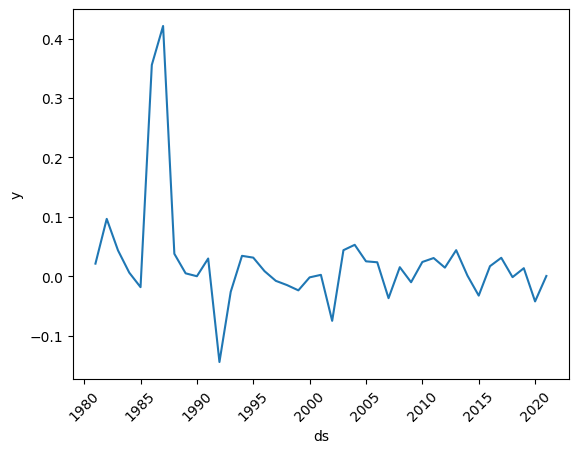

In [17]:
transformed_data = fcst.preprocess(data, dropna=False)
_ = query_country(transformed_data, unique_id ="World", target_col="y").head()

In [18]:
transformed_data.drop(columns=['unique_id', 'ds']).corr()['y']

y                                            1.000000
population_1000s                             0.040327
lag1                                         0.057493
lag2                                         0.021663
lag3                                         0.010537
rolling_mean_lag1_window_size3               0.045919
expanding_mean_lag1                         -0.001032
exponentially_weighted_mean_lag1_alpha0.7    0.062288
expanding_std_lag1                          -0.193121
ratio_over_previous_lag1                     0.076673
ratio_over_previous_lag1_offset2            -0.020361
diff_over_previous_lag1                      0.025729
diff_over_previous_lag1_offset2              0.031006
rolling_mean_lag2_window_size3               0.062191
expanding_mean_lag2                         -0.015075
exponentially_weighted_mean_lag2_alpha0.7    0.027730
expanding_std_lag2                          -0.215318
ratio_over_previous_lag2                     0.040880
ratio_over_previous_lag2_off

# Train and evaluate

In [19]:
# train = train.drop("population_1000s", axis=1)
fcst.fit(train, fitted=True, static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=3, h=5, method="conformal_distribution"))

MLForecast(models=[XGBRegressor], freq=1, lag_features=['lag1', 'lag2', 'lag3', 'rolling_mean_lag1_window_size3', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.7', 'expanding_std_lag1', 'ratio_over_previous_lag1', 'ratio_over_previous_lag1_offset2', 'diff_over_previous_lag1', 'diff_over_previous_lag1_offset2', 'rolling_mean_lag2_window_size3', 'expanding_mean_lag2', 'exponentially_weighted_mean_lag2_alpha0.7', 'expanding_std_lag2', 'ratio_over_previous_lag2', 'ratio_over_previous_lag2_offset2', 'diff_over_previous_lag2', 'diff_over_previous_lag2_offset2', 'rolling_mean_lag3_window_size3', 'expanding_mean_lag3', 'exponentially_weighted_mean_lag3_alpha0.8', 'expanding_std_lag3'], date_features=[], num_threads=6)

In [20]:
# temp_transf = transform_exog(future_df, lags=[1,2], 
#                              lag_transforms={1: [ExpandingMean()]})

In [21]:
# future_df = pd.concat([valid, projections]).drop('y', axis=1)
future_df = valid.drop('y', axis=1)
future_df.shape

(35, 3)

In [22]:
fcst.forecast_fitted_values()

,unique_id,ds,y,XGBRegressor
0,Africa,1986,18689.8950,17803.707031
1,Africa,1987,18981.5745,18813.056641
2,Africa,1988,20654.3857,19901.689453
3,Africa,1989,20556.3645,20785.035156
4,Africa,1990,17186.4987,19849.826172
...,...,...,...,...
212,World,2012,862137.9925,856896.562500
213,World,2013,900812.0370,894084.812500
214,World,2014,901753.3480,913626.937500
215,World,2015,872792.8804,899901.750000


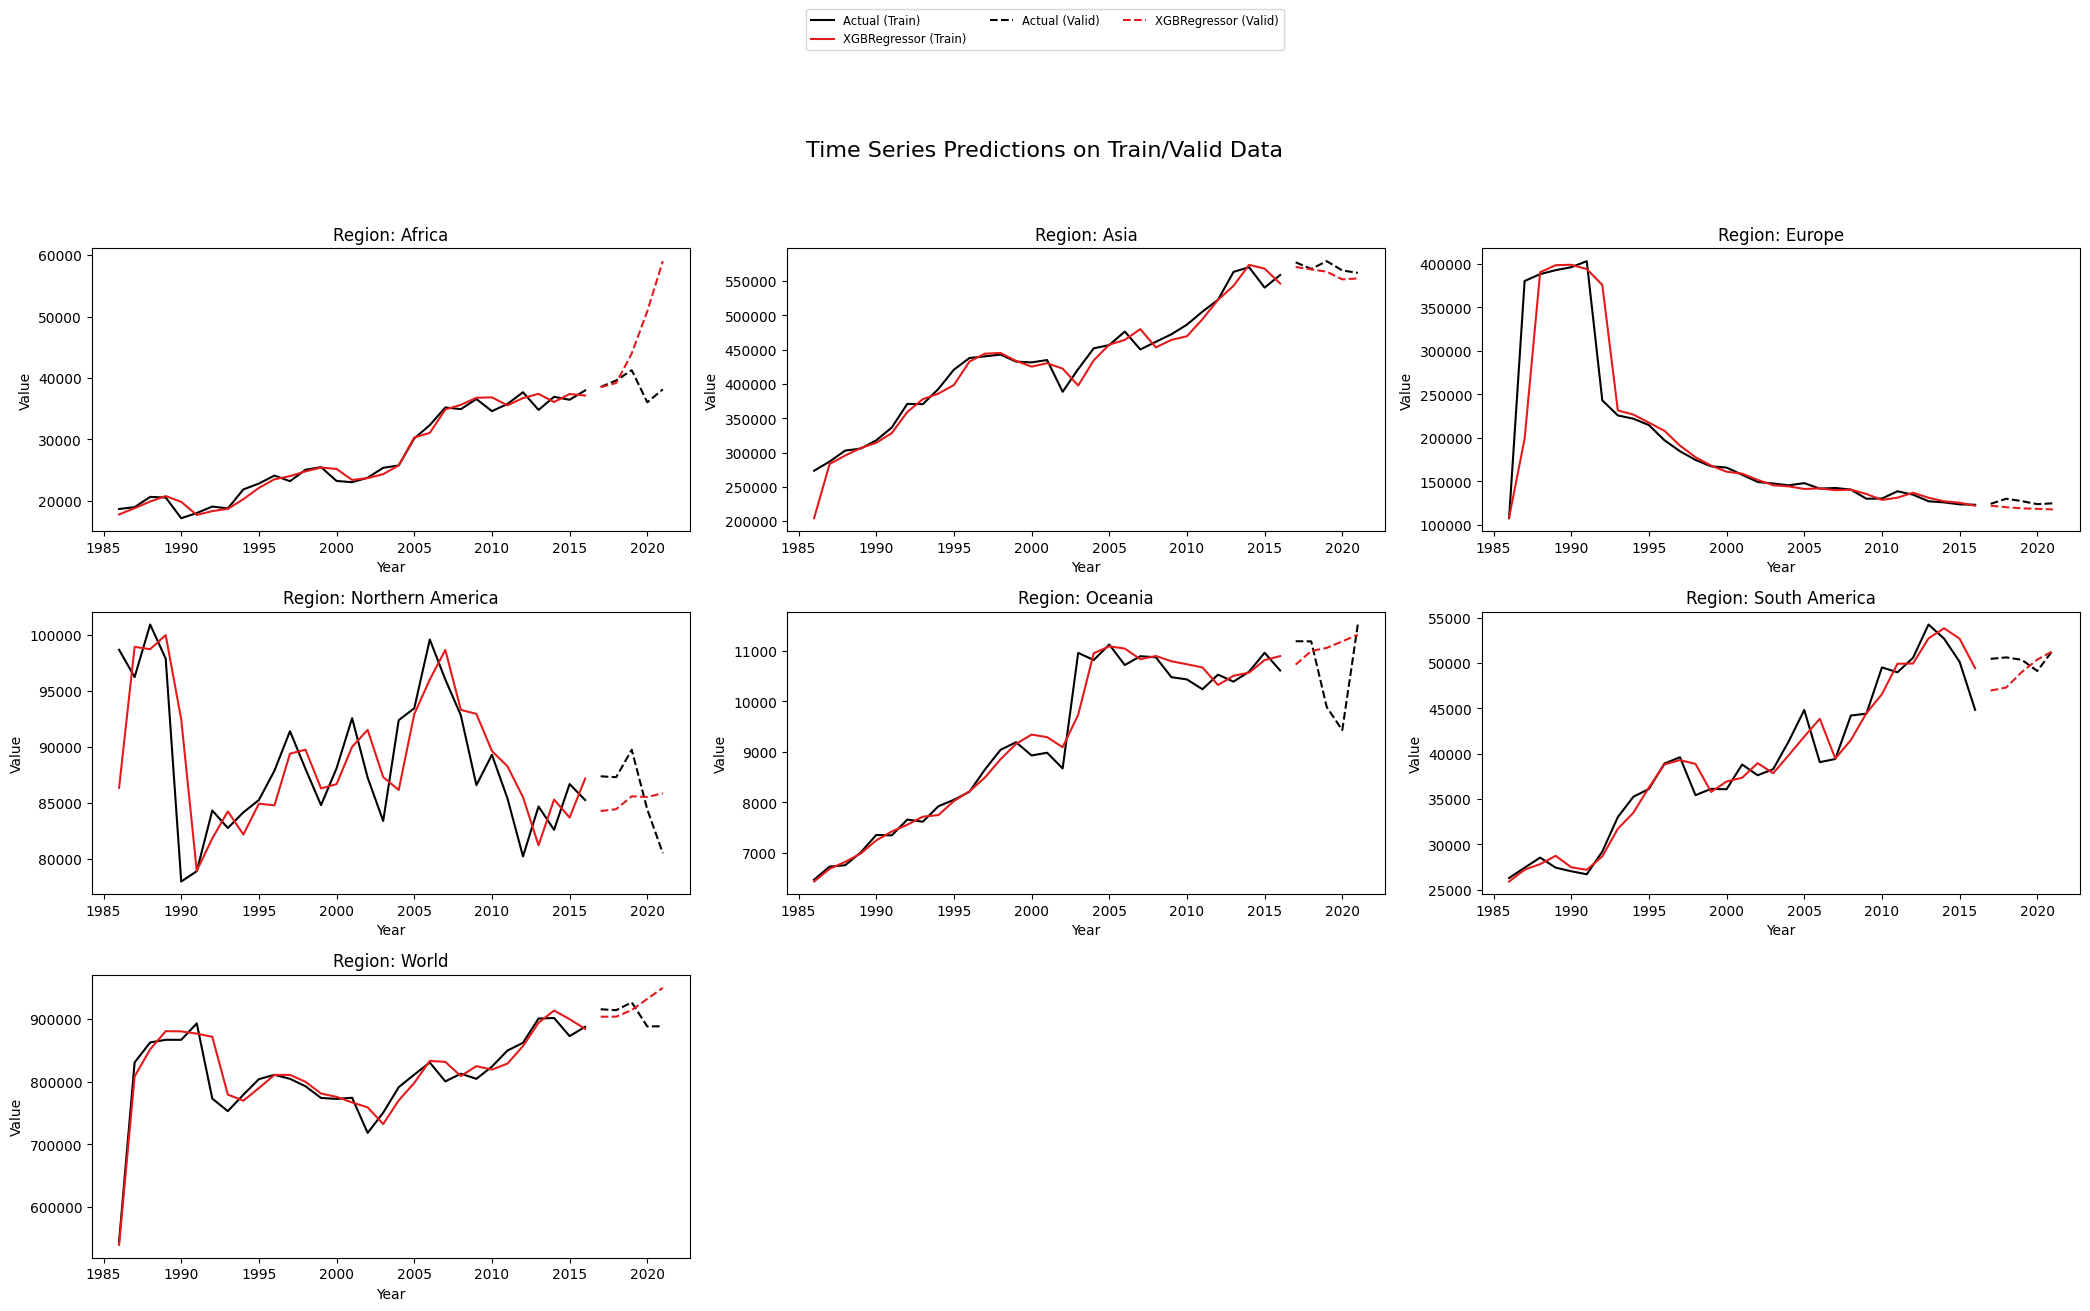

MEAN MAPE_VALID = 6.54%

Model with lowest MAPE validation is XGBRegressor with MAPE = 6.54%

              MAPE_train  MAPE_valid
XGBRegressor    0.032027     0.06541


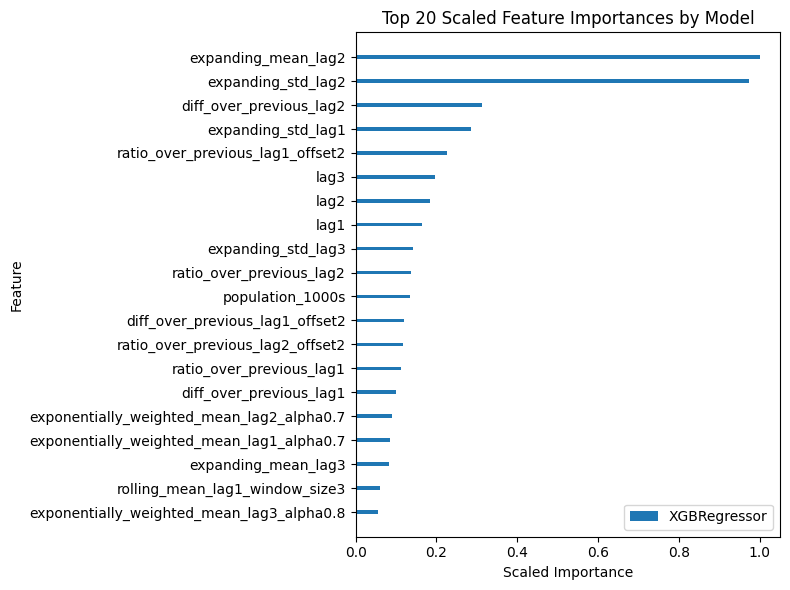

In [23]:
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=5)

# Plot time series
evaluator.plot_time_series()  # If n_samples is not specified, all time series are plotted

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

# Predict up to 2030 with full train

In [24]:
future_df_2030 = projections

In [25]:
future_df_2030.shape

(63, 3)

In [26]:
full_train = pd.concat([train, valid])

# train = train.drop("population_1000s", axis=1)
fcst.fit(full_train, fitted=True, static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=3, h=9, method="conformal_distribution"))

MLForecast(models=[XGBRegressor], freq=1, lag_features=['lag1', 'lag2', 'lag3', 'rolling_mean_lag1_window_size3', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.7', 'expanding_std_lag1', 'ratio_over_previous_lag1', 'ratio_over_previous_lag1_offset2', 'diff_over_previous_lag1', 'diff_over_previous_lag1_offset2', 'rolling_mean_lag2_window_size3', 'expanding_mean_lag2', 'exponentially_weighted_mean_lag2_alpha0.7', 'expanding_std_lag2', 'ratio_over_previous_lag2', 'ratio_over_previous_lag2_offset2', 'diff_over_previous_lag2', 'diff_over_previous_lag2_offset2', 'rolling_mean_lag3_window_size3', 'expanding_mean_lag3', 'exponentially_weighted_mean_lag3_alpha0.8', 'expanding_std_lag3'], date_features=[], num_threads=6)

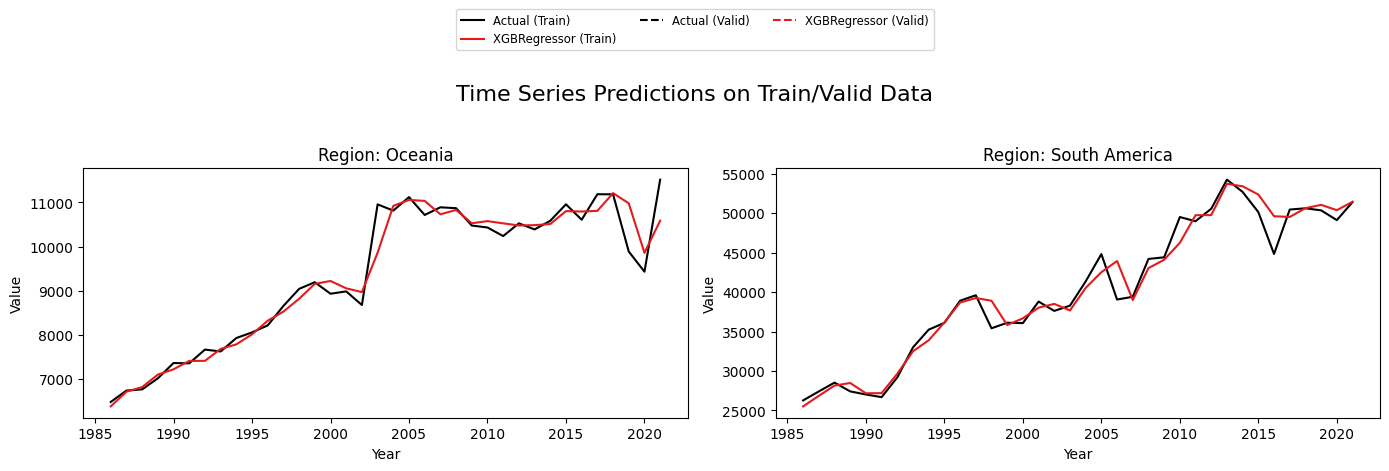

In [27]:
evaluator = MLForecast_Evaluator(fcst, valid, future_df_2030, h=9)

# Plot feature importances sorted by the average importance
evaluator.plot_time_series(n_samples=2)

In [28]:
preds_2030 = fcst.predict(h=9, X_df=future_df_2030, level=[60,70,80,90])
preds_2030

,unique_id,ds,XGBRegressor,XGBRegressor-lo-90,XGBRegressor-lo-80,XGBRegressor-lo-70,XGBRegressor-lo-60,XGBRegressor-hi-60,XGBRegressor-hi-70,XGBRegressor-hi-80,XGBRegressor-hi-90
0,Africa,2022,39439.015082,36172.083991,37022.050309,37872.016627,38721.982945,4.015605e+04,4.100601e+04,4.185598e+04,4.270595e+04
1,Africa,2023,39947.174500,35615.136643,36436.752933,37258.369223,38079.985513,4.181436e+04,4.263598e+04,4.345760e+04,4.427921e+04
2,Africa,2024,42500.163300,35433.044371,36987.119243,38541.194115,40095.268987,4.490506e+04,4.645913e+04,4.801321e+04,4.956728e+04
3,Africa,2025,43059.042856,31326.340105,34037.722279,36749.104453,39460.486627,4.665760e+04,4.936898e+04,5.208036e+04,5.479175e+04
4,Africa,2026,44102.676286,20454.690177,27818.198475,35181.706773,42545.215071,4.566014e+04,5.302365e+04,6.038715e+04,6.775066e+04
...,...,...,...,...,...,...,...,...,...,...,...
58,World,2026,948189.644095,778679.433417,797968.778999,817258.124582,836547.470164,1.059832e+06,1.079121e+06,1.098411e+06,1.117700e+06
59,World,2027,952976.159382,733865.418990,760688.497588,787511.576186,814334.654784,1.091618e+06,1.118441e+06,1.145264e+06,1.172087e+06
60,World,2028,963855.654608,706269.664469,740683.868406,775098.072343,809512.276279,1.118199e+06,1.152613e+06,1.187027e+06,1.221442e+06
61,World,2029,985883.680930,634868.113119,675802.019634,716735.926149,757669.832664,1.214098e+06,1.255031e+06,1.295965e+06,1.336899e+06


In [37]:
def plot_predictions_with_ci(historical_data, forecast_data, 
                             date_col='ds', actual_col='y', 
                             model='XGBRegressor',
                             ci='80',
                             ci2=None,
                             target='Target',
                             region='World'):
    """
    Create a plot of historical data, forecasts, and confidence interval(s).
    
    Parameters:
    - historical_data (pd.DataFrame): DataFrame containing historical data
    - forecast_data (pd.DataFrame): DataFrame containing forecast data and CI
    - date_col (str): Name of the date column
    - actual_col (str): Name of the column with actual values
    - model (str): Name of the model used for predictions
    - ci (str): First confidence interval percentage (e.g., '80' for 80% CI)
    - ci2 (str, optional): Second confidence interval percentage (e.g., '60' for 60% CI)
    - target (str): Name of the target variable
    - region (str): Name of the region being forecasted
    """
    
    ci_low_col = f"{model}-lo-{ci}"
    ci_high_col = f"{model}-hi-{ci}"
    ci_label = f"{ci}% Confidence Interval"

    plt.figure(figsize=(6, 4))
    
    # Plot actual values
    sns.lineplot(x=date_col, y=actual_col, data=historical_data, label="Actual", color='black')
    
    # Plot predictions
    sns.lineplot(x=date_col, y=model, data=forecast_data, label="Prediction", color='darkred')
    
    # Plot first confidence interval as shaded area
    plt.fill_between(forecast_data[date_col], 
                     forecast_data[ci_low_col], 
                     forecast_data[ci_high_col], 
                     alpha=0.3, label=ci_label, color='red')
    
    # Plot second confidence interval if provided
    if ci2:
        ci2_low_col = f"{model}-lo-{ci2}"
        ci2_high_col = f"{model}-hi-{ci2}"
        ci2_label = f"{ci2}% Confidence Interval"
        plt.fill_between(forecast_data[date_col], 
                         forecast_data[ci2_low_col], 
                         forecast_data[ci2_high_col], 
                         alpha=0.15, label=ci2_label, color='blue')
    
    # Customize the plot
    plt.title(f"{target} Predictions for {region}")
    plt.xlabel("Year")
    plt.ylabel(target)
    plt.legend(loc='upper left')
    
     # Ensure the directory exists
    os.makedirs("../plots/forecasts", exist_ok=True)
    
    # Save the plot
    plt.savefig(f"../plots/forecasts/{target}_predictions_{region}.png", dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    print(f"Plot saved as ../plots/forecasts/{target}_predictions_{region}.png")

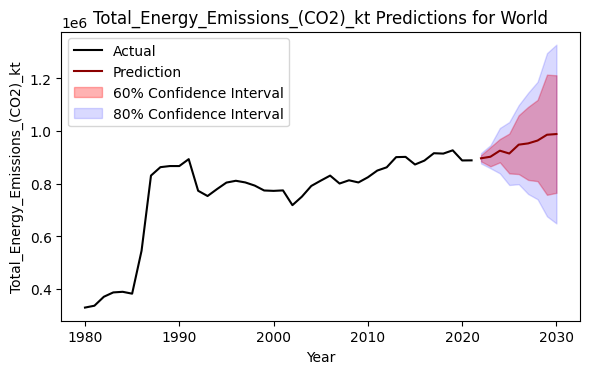

Plot saved as ../plots/forecasts/Total_Energy_Emissions_(CO2)_kt_predictions_World.png


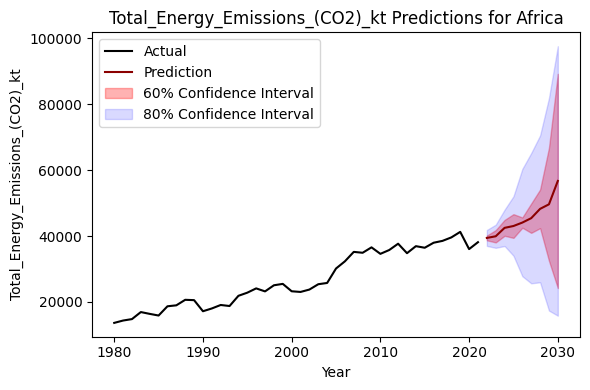

Plot saved as ../plots/forecasts/Total_Energy_Emissions_(CO2)_kt_predictions_Africa.png


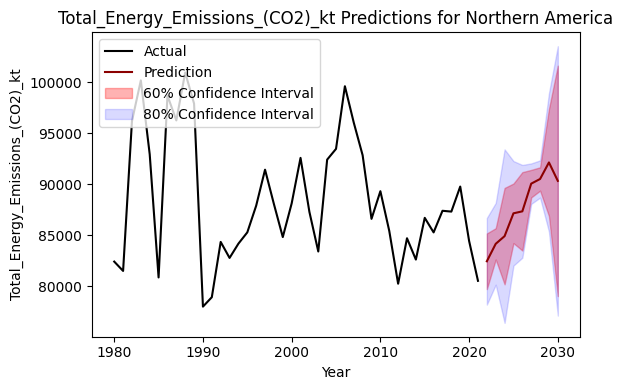

Plot saved as ../plots/forecasts/Total_Energy_Emissions_(CO2)_kt_predictions_Northern America.png


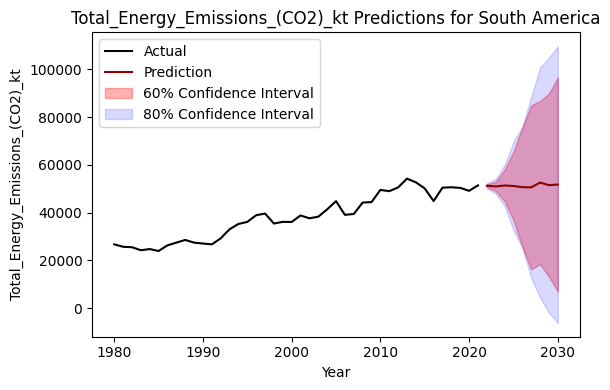

Plot saved as ../plots/forecasts/Total_Energy_Emissions_(CO2)_kt_predictions_South America.png


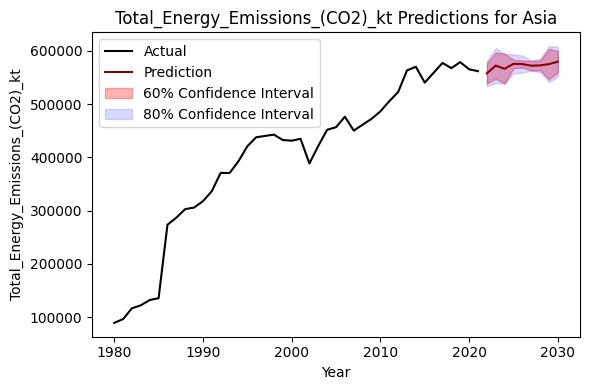

Plot saved as ../plots/forecasts/Total_Energy_Emissions_(CO2)_kt_predictions_Asia.png


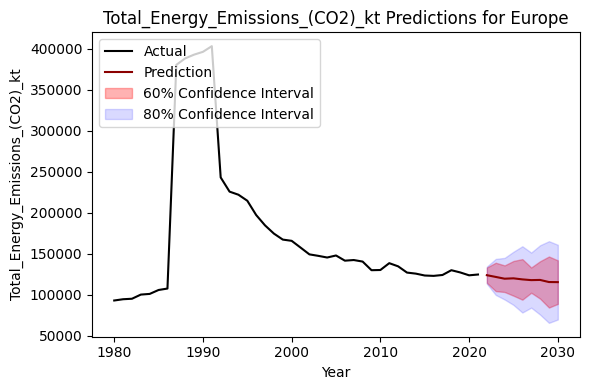

Plot saved as ../plots/forecasts/Total_Energy_Emissions_(CO2)_kt_predictions_Europe.png


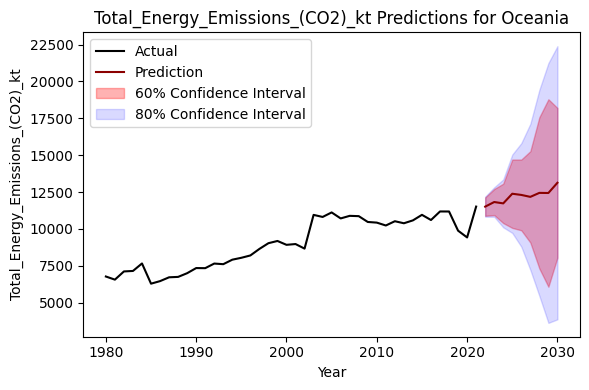

Plot saved as ../plots/forecasts/Total_Energy_Emissions_(CO2)_kt_predictions_Oceania.png


In [38]:
for region in full_train['unique_id'].unique():
    plot_data = full_train[full_train['unique_id'] == region]
    future_data = preds_2030[preds_2030['unique_id'] == region]

    plot_predictions_with_ci(plot_data, future_data, date_col='ds', actual_col='y', 
                                model='XGBRegressor', ci='60', ci2='80', target=target, region=region)